In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from google.colab import drive
from os.path import join

sns.set(style='white', context='notebook', palette='deep')
drive.mount('/content/gdrive')




Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 2. 데이터 로딩과 데이터 확인

### 2.1 데이터 로딩

In [36]:
# Load Data
## Load train and Test Set

train = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/titanic/input/train.csv")
test = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/titanic/input/test.csv")
IDtest = test['PassengerId']

### 2.2 이상 데이터 확인

In [37]:
# Outlier detection

def detect_outliers(df, n, features):
  outlier_indices = []

  # iterate over features(columns)
  for col in features:
    # 1st quartile (25%)
    Q1 = np.percentile(df[col], 25)
    # 3rd quartile (75%)
    Q3 = np.percentile(df[col], 75)
    # Interquartile range (IQR)
    IQR = Q3 - Q1

    # outlier step
    outlier_step = 1.5 * IQR

    # Determine a list of indices of outliers for feature col
    outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

    # append the found outlier indices for col to the list of outlier indices
    outlier_indices.extend(outlier_list_col)

  # select observations containing more than 2 outliers
  outlier_indices = Counter(outlier_indices)
  multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)

  return multiple_outliers

# detect outliers from Age, SibSp, Parch and Fare
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])


In [38]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [39]:
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

In [40]:
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
print(dataset)

      PassengerId  Survived  Pclass  ...      Fare Cabin  Embarked
0               1       0.0       3  ...    7.2500   NaN         S
1               2       1.0       1  ...   71.2833   C85         C
2               3       1.0       3  ...    7.9250   NaN         S
3               4       1.0       1  ...   53.1000  C123         S
4               5       0.0       3  ...    8.0500   NaN         S
...           ...       ...     ...  ...       ...   ...       ...
1294         1305       NaN       3  ...    8.0500   NaN         S
1295         1306       NaN       1  ...  108.9000  C105         C
1296         1307       NaN       3  ...    7.2500   NaN         S
1297         1308       NaN       3  ...    8.0500   NaN         S
1298         1309       NaN       3  ...   22.3583   NaN         C

[1299 rows x 12 columns]


In [41]:
dataset = dataset.fillna(np.nan)

dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [42]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [43]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [44]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [45]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## Feature analysis
### Numerical values

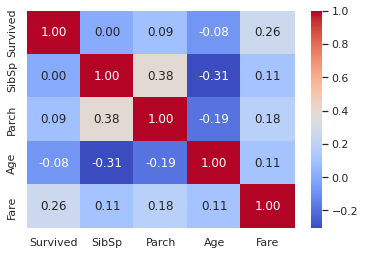

In [46]:
# 숫자형 값들 사이의 상관관계 분석
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot=True, fmt='.2f', cmap='coolwarm')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


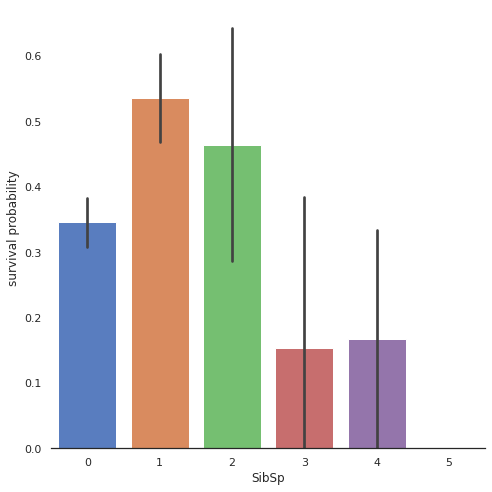

In [47]:
# SibSp와 Survived 간의 상관관계 탐색
g = sns.factorplot(x='SibSp', y='Survived', data=train, kind='bar', size=7, palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


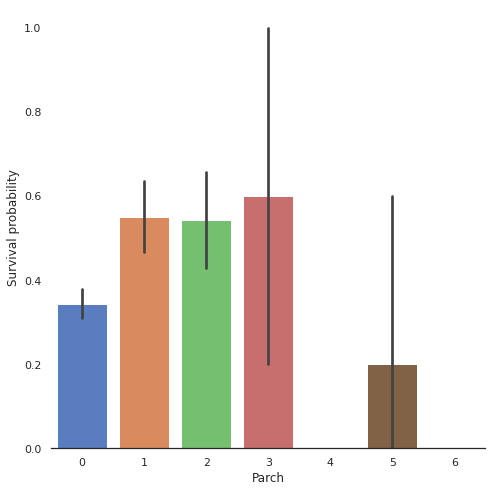

In [48]:
# Parch와 Survived 간의 상관관계 탐색
g = sns.factorplot(x='Parch', y='Survived', data=train, kind='bar', size=7, palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('Survival probability')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


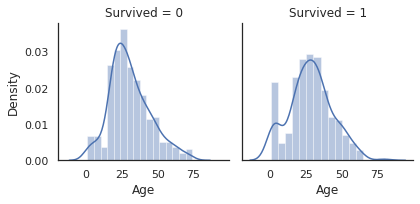

In [49]:
# Age와 Survived 간의 상관관계
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, 'Age')

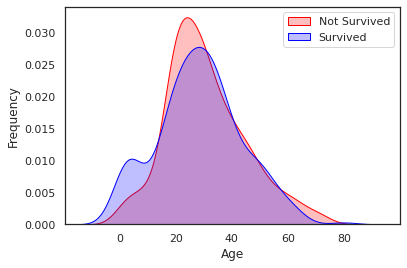

In [50]:
# Age 분포값
g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())], ax =g, color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

In [51]:
# Fare
dataset['Fare'].isnull().sum()

1

In [52]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())
print(dataset['Fare'].median())

14.4542


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


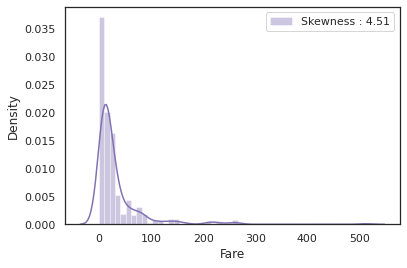

In [53]:
# Fare 분포 확인
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

In [54]:
# Fare 값에 로그를 적용함으로써 모델을 왜곡시킬 수 있는 분포를 줄여줌
dataset['Fare'] = dataset['Fare'].map(lambda x : np.log(x) if x> 0 else 0)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


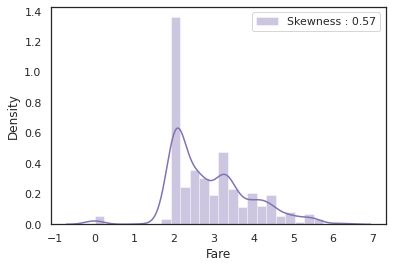

In [55]:
# 로그 적용 이후 분포를 확인
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

## Categorical values
### Sex

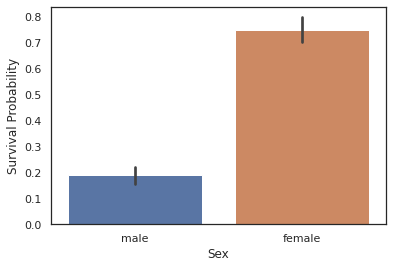

In [56]:
g = sns.barplot(x='Sex', y='Survived', data=train)
g = g.set_ylabel('Survival Probability')

In [57]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


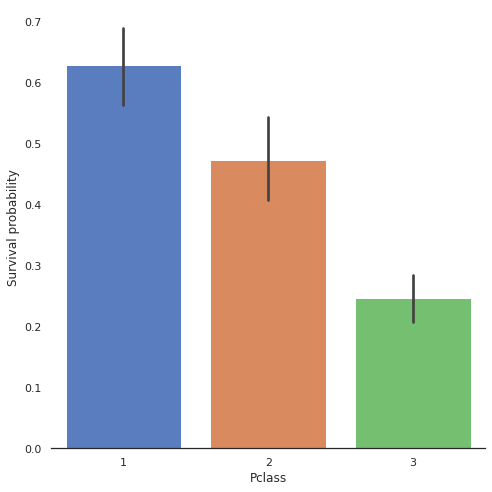

In [58]:
# Pclass와 Survived 사이의 상관관계
g = sns.factorplot(x = 'Pclass', y='Survived', data=train, kind='bar', size=7, palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival probability')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


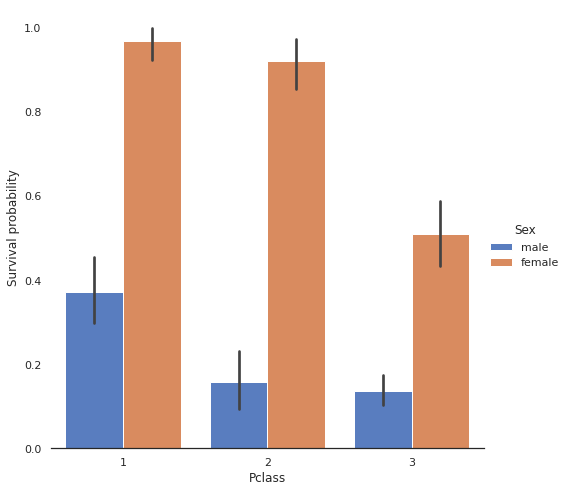

In [59]:
# Pclass와 Survived 사이의 상관관계를 Sex로 나누어 살펴보기
g = sns.factorplot(x='Pclass', y='Survived', hue='Sex', data=train, size=7, kind='bar', palette='muted')
g.despine(left=True)
g = g.set_ylabels('Survival probability')

In [60]:
# Embarked
dataset['Embarked'].isnull().sum()

2

In [61]:
dataset['Embarked'].value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

In [62]:
# S가 다른 값들에 비해 비교적으로 많으므로 S로 채움
dataset['Embarked'] = dataset['Embarked'].fillna('S')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


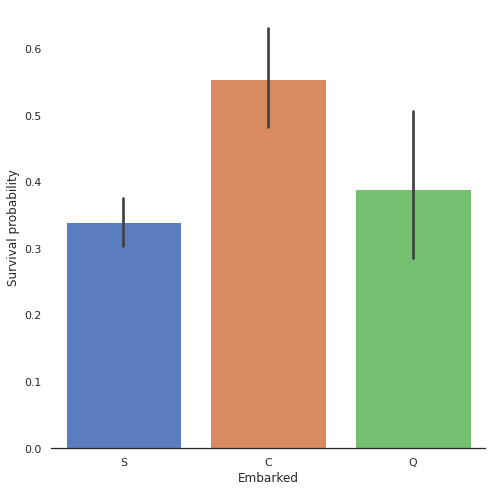

In [63]:
# Embarked와 Survived 간의 상관관계 분석
g = sns.factorplot(x='Embarked', y='Survived', data=train, size=7, kind='bar', palette='muted')
g.despine(left=True)
g=g.set_ylabels('Survival probability')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3723: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


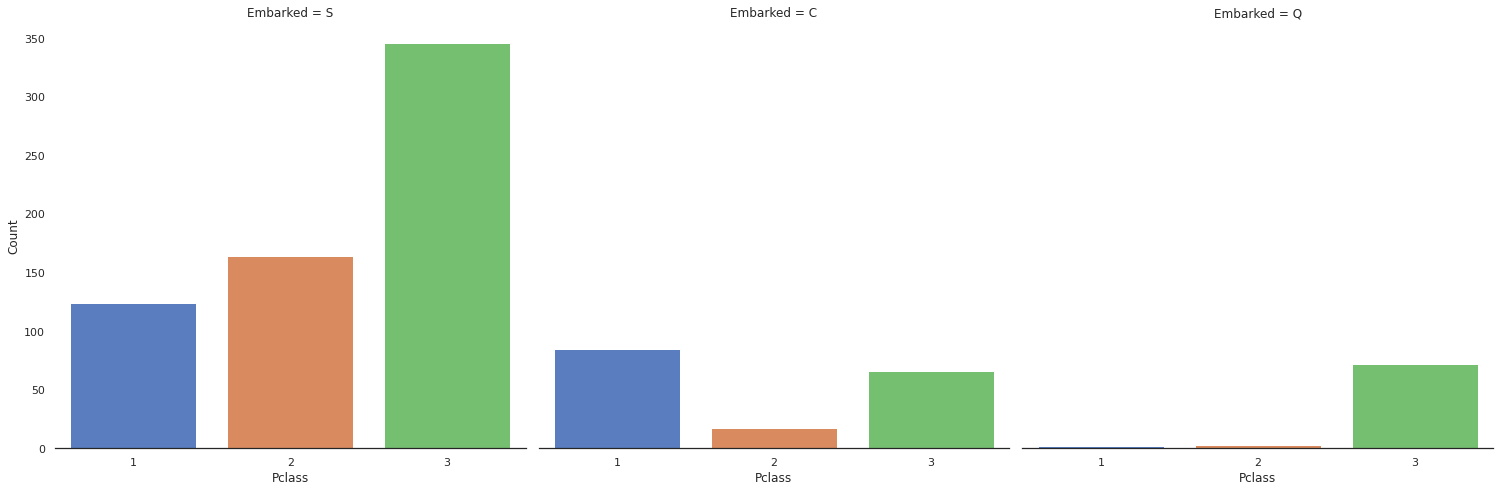

In [64]:
# Pclass와 Embarked 사이의 상관관계 분석
g = sns.factorplot('Pclass', col='Embarked', data=train, size=7,kind='count', palette='muted')
g.despine(left=True)
g = g.set_ylabels("Count")

## Filling missing values
### Age

In [65]:
dataset['Age'].isnull().sum()

256

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr

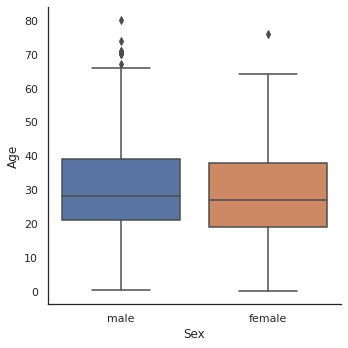

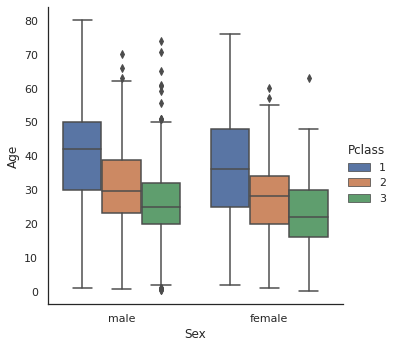

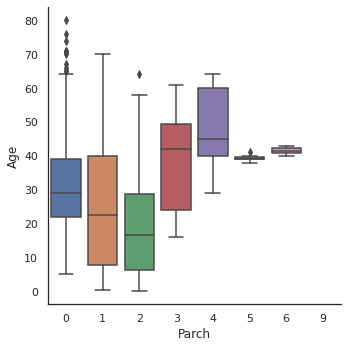

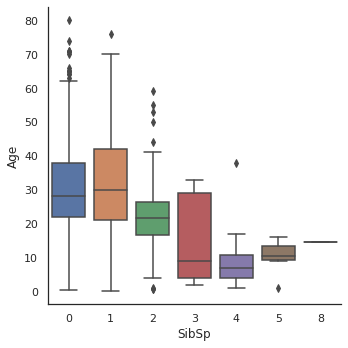

In [66]:
# Age 피처와 다른 피처들관의 상관관계 분석
g = sns.factorplot(y='Age', x='Sex', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='Sex', hue='Pclass', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='Parch', data=dataset, kind='box')
g = sns.factorplot(y='Age', x='SibSp', data=dataset, kind='box')

In [67]:
# Sex 값을 0과 1로 바꾸기
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

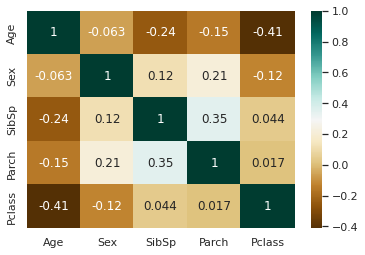

In [68]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap='BrBG', annot=True)

In [72]:
# 값이 없는 Age를 채워준다
## Pclass, Parch, SibSp의 값에 따라 가장 비슷한 row들을 찾아 Age의 평균값을 찾는다

# 값이 없는(NaN) 로우의 인덱스를 찾는다
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
  age_med = dataset['Age'].median()
  age_pred = dataset['Age'][( (dataset['SibSp'] == dataset.iloc[i]['SibSp']) & (dataset['Parch'] == dataset.iloc[i]['Parch']) & (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()

  if not np.isnan(age_pred):
    dataset['Age'].iloc[i] = age_pred
  else:
    dataset['Age'].iloc[i] = age_med

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


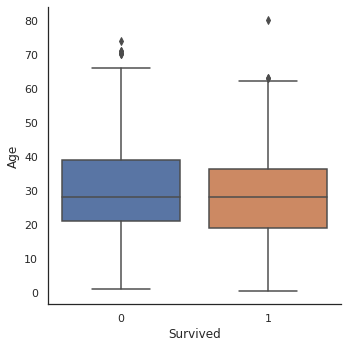

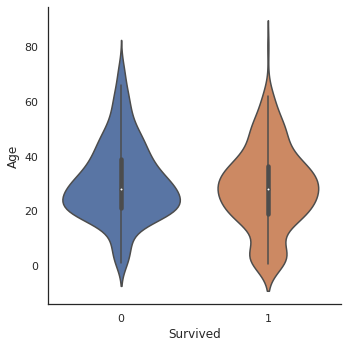

In [73]:
g = sns.factorplot(x='Survived', y='Age', data=train, kind='box')
g = sns.factorplot(x='Survived', y='Age', data=train, kind='violin')

## Feature engineering
### Name/Title

In [74]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [77]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

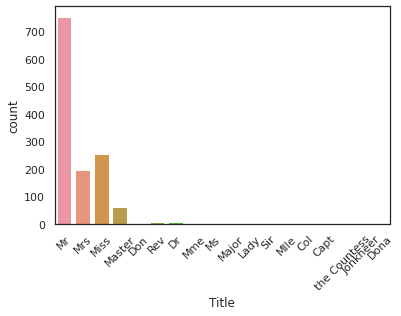

In [78]:
g = sns.countplot(x='Title', data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [79]:
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].map({'Master':0, 'Miss':1, 'Ms' : 1 , 'Mme':1, 'Mlle':1, 'Mrs':1, 'Mr':2, 'Rare':3 })
dataset['Title'] = dataset['Title'].astype(int)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


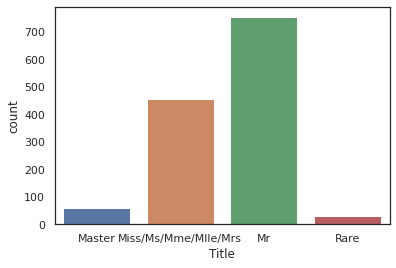

In [81]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


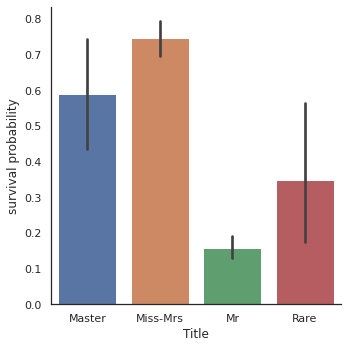

In [83]:
g = sns.factorplot(x="Title", y="Survived", data=dataset, kind="bar")
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('survival probability')

In [84]:
# Title 피처로 이름을 대체했으니 Name 피처를 드랍한다
dataset.drop(labels=['Name'], axis=1, inplace=True)

### Family size

In [85]:
# Fize라는 이름의 피처를 만듭니다.
# 이는 Family size를 줄인 말로, SibSp(형제 자매의 수) + Parch(부모의 수) + 1(자기 자신)을 한 값입니다.
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


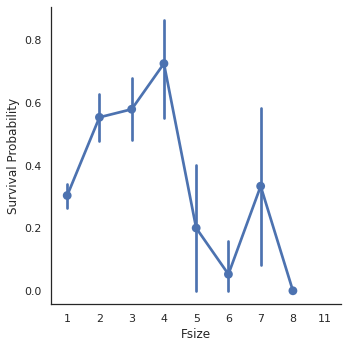

In [86]:
g = sns.factorplot(x='Fsize', y='Survived', data =dataset)
g = g.set_ylabels('Survival Probability')

In [90]:
# Fsize를 4개의 카테고리로 분류합니다
## Single : 1명으로 이루어진 가족
## SmallF : 2명으로 이루어진 가족
## MedF : 3, 4명으로 이루어진 가족
## LargeF : 5명 이상으로 이루어진 가족

dataset['Single'] = dataset['Fsize'].map(lambda x : 1 if x == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda x : 1 if x == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda x : 1 if 3<=x <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda x : 1 if 5<=x else 0)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr

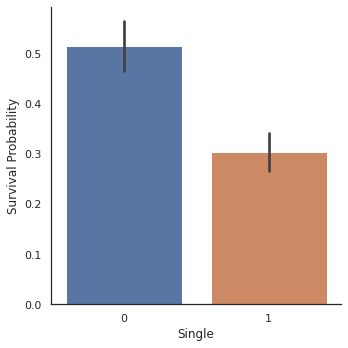

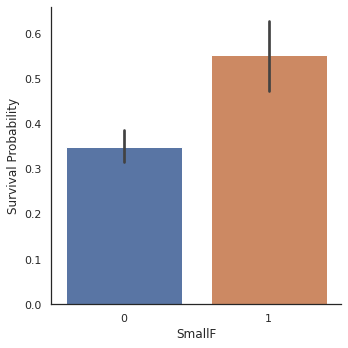

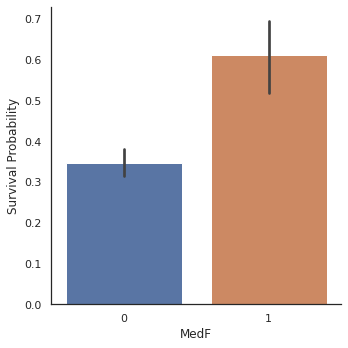

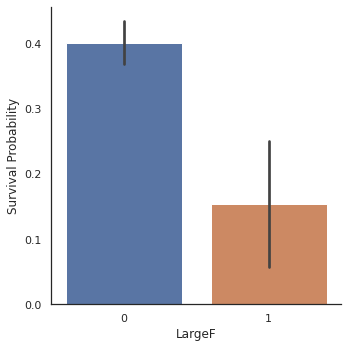

In [91]:
g = sns.factorplot(x='Single', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.factorplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.factorplot(x='MedF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.factorplot(x='LargeF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival Probability')

In [92]:
# Title 피처와 Embarked 피처를 지표화 합니다
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix='Em')

In [93]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,2,0,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,2,0,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,1,1,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,2,0,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,1,1,0,0,0,0,0,1,0,0,0,1


### Cabin

In [94]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [95]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [96]:
dataset['Cabin'].isnull().sum()

1007

In [98]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [99]:
dataset['Cabin'] = pd.Series(i[0] if pd.notnull(i) else 'X' for i in dataset['Cabin'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


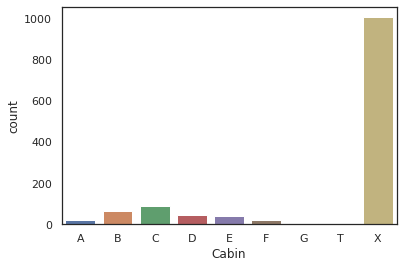

In [100]:
g = sns.countplot(dataset['Cabin'], order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


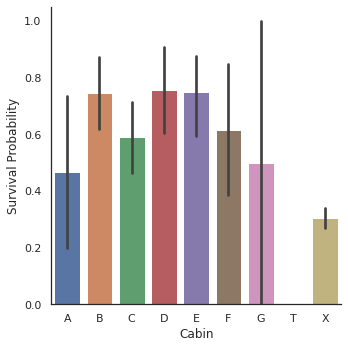

In [101]:
g = sns.factorplot(x='Cabin', y= 'Survived', kind='bar', data=dataset, order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])
g = g.set_ylabels('Survival Probability')

In [102]:
dataset = pd.get_dummies(dataset, columns =['Cabin'], prefix='Cabin')

In [103]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,2,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,2,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,2,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,5,0.0,3,0,35.0,0,0,373450,2.085672,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1


### Ticket

In [105]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [106]:
Ticket = []
for i in list(dataset.Ticket):
  if not i.isdigit():
    Ticket.append(i.replace('.', '').replace('/', '').strip().split(' ')[0])
  else:
    Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [107]:
dataset = pd.get_dummies(dataset, columns = ['Ticket'], prefix='T')

In [108]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,T_A,T_A4,T_A5,T_AQ3,T_AQ4,T_AS,T_C,T_CA,T_CASOTON,T_FC,T_FCC,T_Fa,T_LINE,T_LP,T_PC,T_PP,T_PPP,T_SC,T_SCA3,T_SCA4,T_SCAH,T_SCOW,T_SCPARIS,T_SCParis,T_SOC,T_SOP,T_SOPP,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X
0,1,0.0,3,0,22.0,1,0,1.981001,2,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1.0,1,1,38.0,1,0,4.266662,2,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1.0,3,1,26.0,0,0,2.070022,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,4,1.0,1,1,35.0,1,0,3.972177,2,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,2.085672,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [109]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns=['Pclass'], prefix='Pc')

In [110]:
dataset.head()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,T_A,T_A4,T_A5,T_AQ3,T_AQ4,T_AS,T_C,T_CA,T_CASOTON,T_FC,T_FCC,T_Fa,T_LINE,T_LP,T_PC,T_PP,T_PPP,T_SC,T_SCA3,T_SCA4,T_SCAH,T_SCOW,T_SCPARIS,T_SCParis,T_SOC,T_SOP,T_SOPP,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,1,0.0,0,22.0,1,0,1.981001,2,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,2,1.0,1,38.0,1,0,4.266662,2,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,1.0,1,26.0,0,0,2.070022,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,4,1.0,1,35.0,1,0,3.972177,2,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,5,0.0,0,35.0,0,0,2.085672,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


# Modeling

In [112]:
## train 세트와 test 세트를 나눠줍니다

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [113]:
## train 피처와 라벨(결과값, Survived)를 나눠줍니다
train['Survived'] = train['Survived'].astype(int)

Y_train = train['Survived']

X_train = train.drop(labels=['Survived'], axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
